In [3]:
# %pip install numpy
# %pip install -U scikit-learn imbalanced-learn
# %pip install pillow
# %pip install kagglehub
# %pip install monai
# %pip install matplotlib
# %pip install pylatexenc
# %pip install opencv-python
# %pip install qiskit
# %pip install qiskit_machine_learning
# %pip install joblib
# %pip install pandas
# %pip install seaborn
# %pip install imblearn

In [25]:
import os
import pickle
import numpy as np
import pandas as pd
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from monai.transforms import ScaleIntensity
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import kagglehub
import torch
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.utils.validation import check_array
from sklearn.model_selection import train_test_split
from qiskit_machine_learning.algorithms import QSVC
from qiskit.circuit.library import ZZFeatureMap
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit_machine_learning.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

import warnings
warnings.filterwarnings('ignore')

#### Download latest version https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

In [26]:
path = kagglehub.dataset_download(r"navoneel/brain-mri-images-for-brain-tumor-detection")
# print("Path to dataset files:", path)

#### Define dataset paths
#### !!! Remove .DS_Store from folders

In [3]:
# !rm -rf {path}/brain_tumor_dataset/yes/.DS_Store
# !rm -rf {path}/brain_tumor_dataset/no/.DS_Store

In [27]:
dataset_path_tumor = f'{path}/brain_tumor_dataset/yes'
dataset_path_norma = f'{path}/brain_tumor_dataset/no'

#### Count files in directory

In [28]:
def count_images(directory):
    return len([f for f in os.listdir(directory) if f.endswith(('.jpg', '.JPG', '.png', '.PNG', '.jpeg'))])

print("Length dataset_path_tumor:", count_images(dataset_path_tumor))
print("Length dataset_path_norma:", count_images(dataset_path_norma))

Length dataset_path_tumor: 155
Length dataset_path_norma: 98


#### Check data

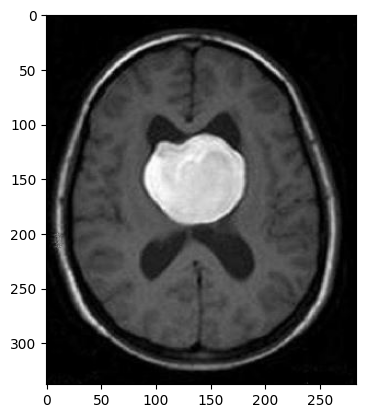

In [29]:
mri_image = cv2.imread(f'{dataset_path_tumor}/Y253.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(mri_image, cmap='gray')

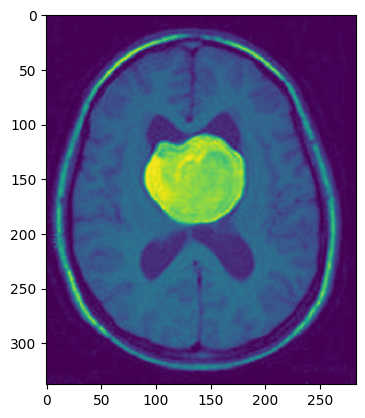

In [30]:
transform_img = ScaleIntensity(minv=0.0, maxv=1.0)
mri_image_scaled = transform_img(mri_image)
colored_mri = cm.viridis(mri_image_scaled)
plt.imshow(colored_mri)

#### Load and preprocess the images

In [31]:
img_size = (224, 224)

def load_images_from_folder(folder, label, target_size=img_size):
    """
    Loads images from a given folder and resizes them to the specified target size.
    Converts images to RGB and flattens them into numpy arrays.

    Args:
        folder (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of image data and their corresponding labels.
    """
    data, labels = [], []
    for img_name in os.listdir(folder):
        img_path = os.path.join(folder, img_name)
        try:
            img = Image.open(img_path).convert("RGB").resize(target_size)
            data.append(np.array(img).flatten())
            labels.append(label)
        except Exception as e:
            print(f"Error loading image {img_name}: {e}")
    return data, labels

def load_and_limit_data(path, label, num_samples, target_size=img_size):
    """
    Loads and limits the number of images from a folder to a specified number of samples.
    Ensures images are resized to the specified target size.

    Args:
        path (str): Path to the folder containing images.
        label (int): Label associated with the images in the folder.
        num_samples (int): Maximum number of samples to load.
        target_size (tuple): Target size to which images will be resized (width, height).

    Returns:
        tuple: A list of limited image data and their corresponding labels.
    """
    data, labels = load_images_from_folder(path, label, target_size)
    indices = np.random.choice(len(data), min(num_samples, len(data)), replace=False)
    data = [data[i] for i in indices]
    labels = [labels[i] for i in indices]
    return data, labels

#### Display images for train

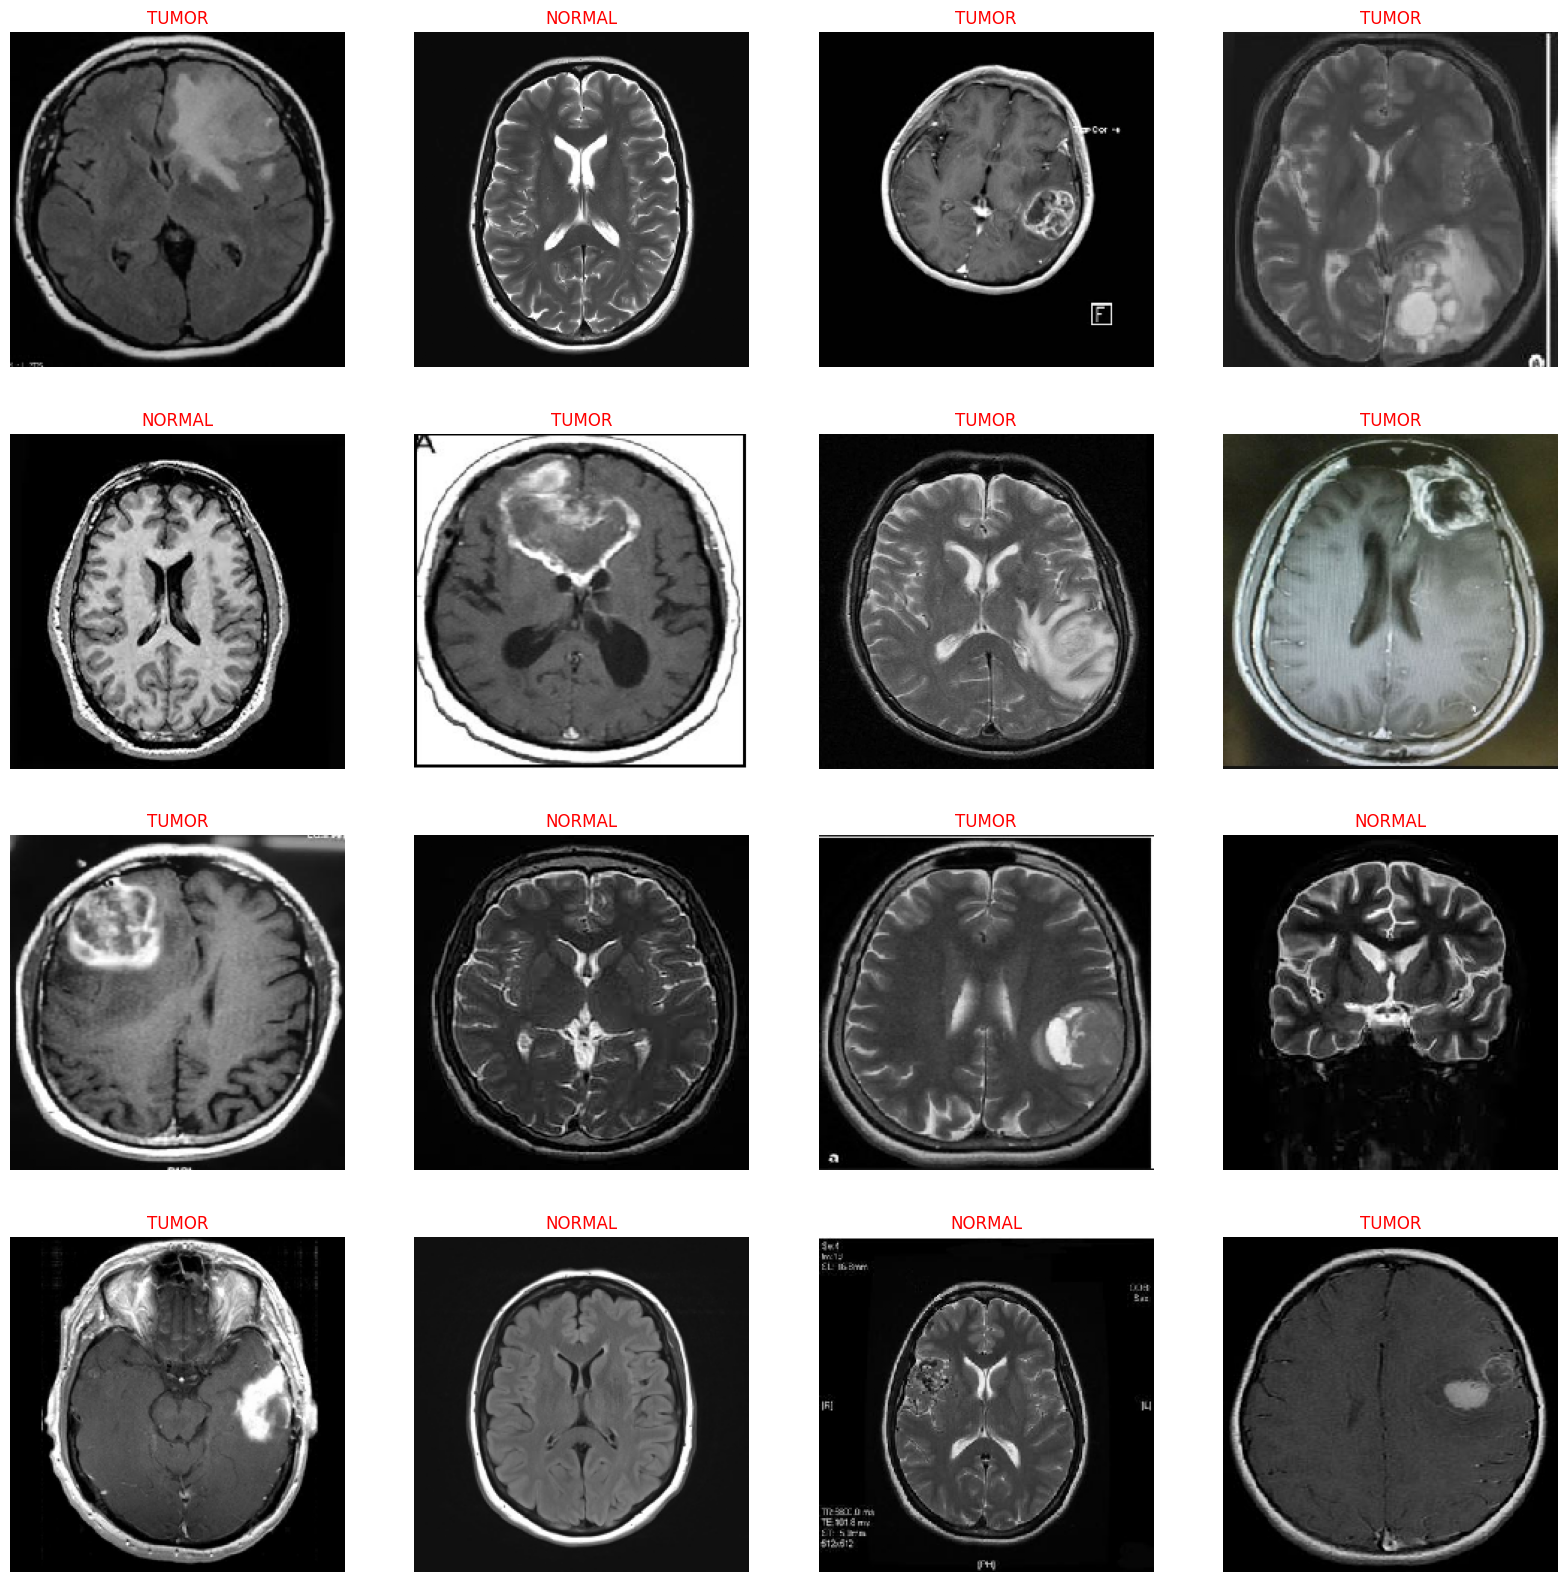

In [32]:
def load_file_paths_and_labels(directory, label):
    filepaths = [os.path.join(directory, fname) for fname in os.listdir(directory) if os.path.isfile(os.path.join(directory, fname))]
    labels = [label] * len(filepaths)
    return filepaths, labels

tumor_filepaths, tumor_labels = load_file_paths_and_labels(dataset_path_tumor, 'TUMOR')
normal_filepaths, normal_labels = load_file_paths_and_labels(dataset_path_norma, 'NORMAL')

all_filepaths = tumor_filepaths + normal_filepaths
all_labels = tumor_labels + normal_labels

combined = list(zip(all_filepaths, all_labels))
np.random.shuffle(combined)
all_filepaths, all_labels = zip(*combined)

label_to_index = {'TUMOR': 0, 'NORMAL': 1}
categorical_labels = np.array([label_to_index[label] for label in all_labels])

def scalar(img):
    return img

def custom_generator(filepaths, labels, batch_size, img_size, preprocessing_function=None):
    while True:
        for i in range(0, len(filepaths), batch_size):
            batch_filepaths = filepaths[i:i + batch_size]
            batch_labels = labels[i:i + batch_size]
            
            images = []
            for filepath in batch_filepaths:
                img = load_img(filepath, target_size=img_size)
                img_array = img_to_array(img)
                if preprocessing_function:
                    img_array = preprocessing_function(img_array)
                images.append(img_array)
            
            yield np.array(images), np.array(batch_labels)

img_size = img_size
batch_size = 32

train_gen = custom_generator(all_filepaths, categorical_labels, batch_size, img_size, preprocessing_function=scalar)

images, labels = next(train_gen)

classes = list(label_to_index.keys())

plt.figure(figsize=(20, 20))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    image = images[i] / 255
    plt.imshow(image)
    class_index = labels[i]
    class_name = classes[class_index]
    plt.title(class_name, color='red', fontsize=12)
    plt.axis('off')

plt.show()

#### Prepare & preprocess data

In [33]:
tumor_data, tumor_labels = load_and_limit_data(dataset_path_tumor, label=1, num_samples=155)
normal_data, normal_labels = load_and_limit_data(dataset_path_norma, label=0, num_samples=98)

all_data = tumor_data + normal_data
all_labels = tumor_labels + normal_labels

X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=42)  # (80% train, 20% test)

#### Train data

In [34]:
pca = PCA(n_components=8)
X_train_pca = pca.fit_transform(X_train)

X_train_pca_validated = check_array(X_train_pca, accept_sparse=True)

smote = SMOTE()
X_train_pca_resampled, y_train_resampled = smote.fit_resample(X_train_pca_validated, y_train)

X_train_tensor = torch.tensor(X_train_pca_resampled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_resampled, dtype=torch.long)

#### Test data

In [35]:
X_test_pca = pca.transform(X_test)

X_test_tensor = torch.tensor(X_test_pca, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

#### Ensure data is in NumPy format for SVC

In [36]:
X_train_numpy = X_train_tensor.numpy()
y_train_numpy = y_train_tensor.numpy()
X_test_numpy = X_test_tensor.numpy()
y_test_numpy = y_test_tensor.numpy()

#### Display the categorized file paths and labels

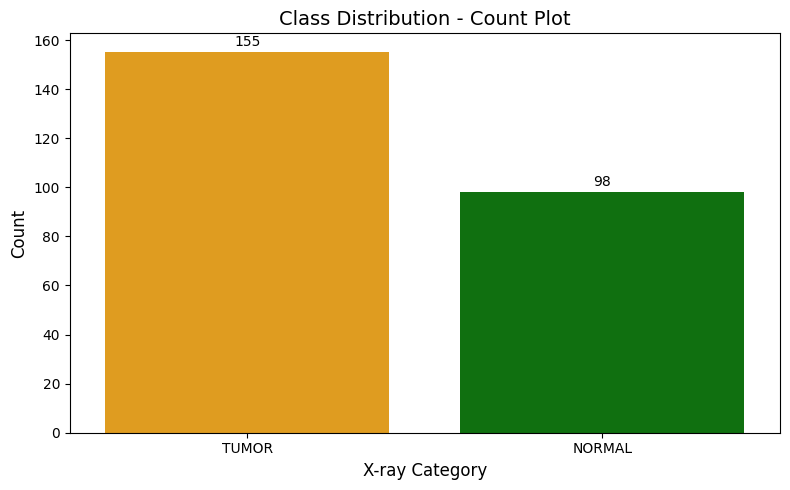

In [37]:
df = pd.DataFrame({'label': ['NORMAL' if lbl == 0 else 'TUMOR' for lbl in all_labels]})

plt.figure(figsize=(8, 5))
ax = sns.countplot(
    data=df, 
    x='label', 
    hue='label',
    palette={'NORMAL': 'green', 'TUMOR': 'orange'},
    dodge=False,
    legend=False
)

plt.title('Class Distribution - Count Plot', fontsize=14)
plt.xlabel('X-ray Category', fontsize=12)
plt.ylabel('Count', fontsize=12)

for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='center', 
                xytext=(0, 7.5), textcoords='offset points')

plt.tight_layout()
plt.show()

#### Plot the data

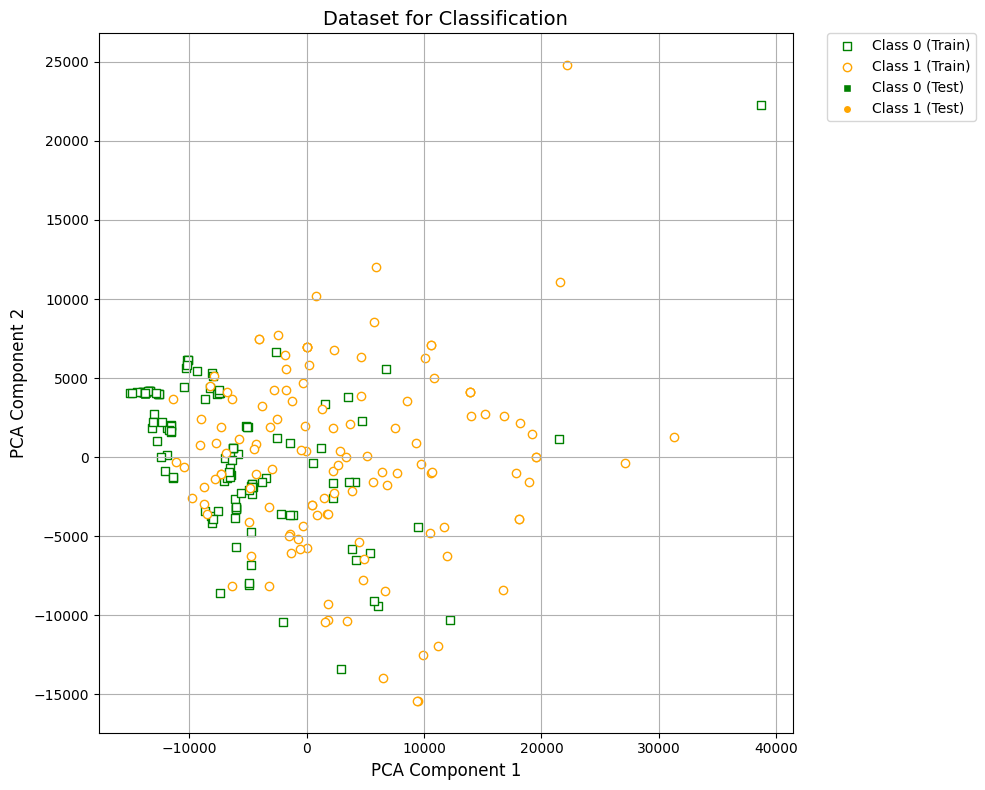

In [38]:
plt.figure(figsize=(10, 8))

plt.scatter(
    X_train_tensor[(y_train_tensor == 0), 0].numpy(),
    X_train_tensor[(y_train_tensor == 0), 1].numpy(),
    marker="s",
    facecolors="w",
    edgecolors="green",
    label="Class 0 (Train)",
)

plt.scatter(
    X_train_tensor[(y_train_tensor == 1), 0].numpy(),
    X_train_tensor[(y_train_tensor == 1), 1].numpy(),
    marker="o",
    facecolors="w",
    edgecolors="orange",
    label="Class 1 (Train)",
)

plt.scatter(
    X_test_pca[y_test == 0, 0],
    X_test_pca[y_test == 0, 1],
    marker="s",
    facecolors="green",
    edgecolors="w",
    label="Class 0 (Test)",
)

plt.scatter(
    X_test_pca[y_test == 1, 0],
    X_test_pca[y_test == 1, 1],
    marker="o",
    facecolors="orange",
    edgecolors="w",
    label="Class 1 (Test)",
)

plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0)
plt.title("Dataset for Classification", fontsize=14)
plt.xlabel("PCA Component 1", fontsize=12)
plt.ylabel("PCA Component 2", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


#### feature_map and quantum kernel

In [39]:
feature_map = ZZFeatureMap (feature_dimension=4, reps=2, entanglement="linear")
sampler = Sampler()
fidelity = ComputeUncompute(sampler=sampler)
kernel = FidelityQuantumKernel(fidelity=fidelity, feature_map=feature_map)

#### Fit models

In [40]:
svc = SVC(kernel=kernel.evaluate)

svc.fit(X_train_numpy, y_train_numpy)

score_callable_function = svc.score(X_test_numpy, y_test_numpy)

print(f"Callable kernel classification test score: {score_callable_function}")

Callable kernel classification test score: 0.5098039215686274


In [41]:
matrix_train = kernel.evaluate(x_vec=X_train_numpy)
matrix_test = kernel.evaluate(x_vec=X_test_numpy, y_vec=X_train_numpy)

#### Save kernels to a file

In [42]:
with open('kernels/FidelityQuantumKernel_matrix_train.pkl', 'wb') as f:
    pickle.dump(matrix_train, f)

with open('kernels/FidelityQuantumKernel_matrix_test.pkl', 'wb') as f:
    pickle.dump(matrix_test, f)

#### Load the kernel from the file

In [ ]:
with open('kernels/FidelityQuantumKernel_matrix_train.pkl', 'rb') as f:
    loaded_kernel_matrix_train = pickle.load(f)

with open('kernels/FidelityQuantumKernel_matrix_test.pkl', 'rb') as f:
    loaded_kernel_matrix_test = pickle.load(f)

In [43]:
svc = SVC(kernel="precomputed")

svc.fit(matrix_train, y_train_numpy)

score_precomputed_kernel = svc.score(matrix_test, y_test_numpy)

print(f"Precomputed kernel classification test score: {score_precomputed_kernel}")

Precomputed kernel classification test score: 0.49019607843137253


In [44]:
qsvc = QSVC(quantum_kernel=kernel)

qsvc.fit(X_train_numpy, y_train_numpy)

qsvc_score = qsvc.score(X_test_numpy, y_test_numpy)

print(f"QSVC classification test score: {qsvc_score}")

QSVC classification test score: 0.5294117647058824


#### Save model

In [45]:
qsvc.save('models/QSVC_Fidelity_quantm_trainer_brain_tumor.model')

#### Load model

In [ ]:
loaded_model = QSVC.load('models/QSVC_Fidelity_quantm_trainer_brain_tumor.model')

#### Compute evaluation metrics

In [46]:
y_pred = qsvc.predict(X_test_numpy)

In [47]:
classification_rep = metrics.classification_report(y_test_numpy, y_pred, output_dict=True, zero_division=True)
conf_matrix = metrics.confusion_matrix(y_test_numpy, y_pred)
roc_auc = metrics.roc_auc_score(y_test_numpy, qsvc.decision_function(X_test_numpy))

print("Classification Report:", classification_rep)
print("Confusion Matrix:\n", conf_matrix)
print(f"ROC AUC Score: {roc_auc}")

Classification Report: {'0': {'precision': 0.46153846153846156, 'recall': 0.5, 'f1-score': 0.48, 'support': 24.0}, '1': {'precision': 0.52, 'recall': 0.48148148148148145, 'f1-score': 0.5, 'support': 27.0}, 'accuracy': 0.49019607843137253, 'macro avg': {'precision': 0.4907692307692308, 'recall': 0.4907407407407407, 'f1-score': 0.49, 'support': 51.0}, 'weighted avg': {'precision': 0.49248868778280547, 'recall': 0.49019607843137253, 'f1-score': 0.49058823529411766, 'support': 51.0}}
Confusion Matrix:
 [[12 12]
 [14 13]]
ROC AUC Score: 0.6157407407407407


#### Predicted probability for Positive Class

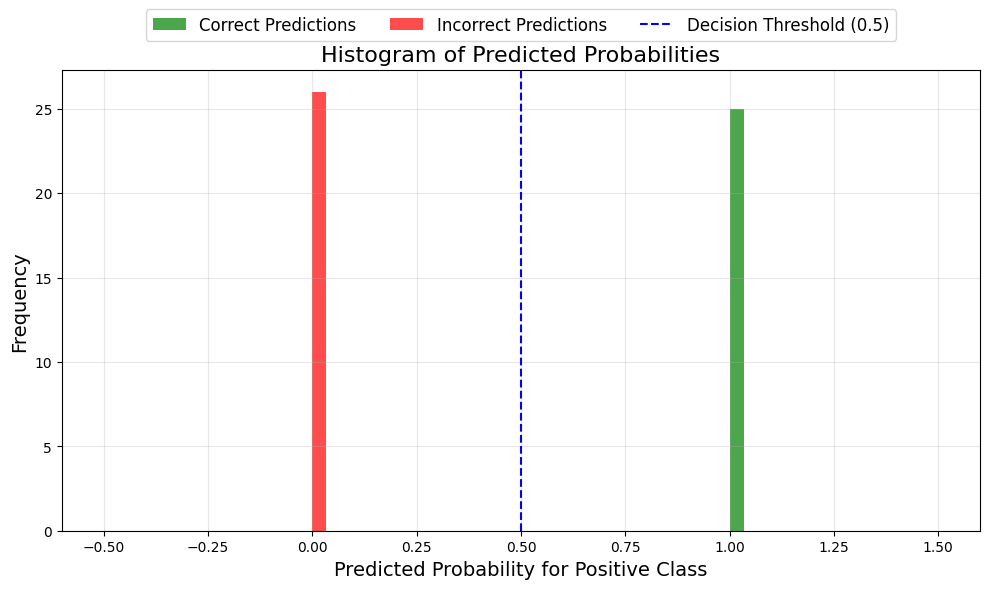

In [48]:
if isinstance(y_pred, np.ndarray):
    y_pred = torch.tensor(y_pred, dtype=torch.float32)

predictions = torch.round(y_pred)
correct_predictions = (predictions == 1)
incorrect_predictions = ~correct_predictions

correct_probs = y_pred[correct_predictions]
incorrect_probs = y_pred[incorrect_predictions]

plt.figure(figsize=(10, 6))

plt.hist(
    correct_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='green', 
    label='Correct Predictions'
)

plt.hist(
    incorrect_probs.numpy(), 
    bins=30, 
    alpha=0.7, 
    color='red', 
    label='Incorrect Predictions'
)

plt.axvline(0.5, color='blue', linestyle='--', label='Decision Threshold (0.5)', linewidth=1.5)

plt.title('Histogram of Predicted Probabilities', fontsize=16)
plt.xlabel('Predicted Probability for Positive Class', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=4, fontsize=12)
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

#### PCA of model prediction

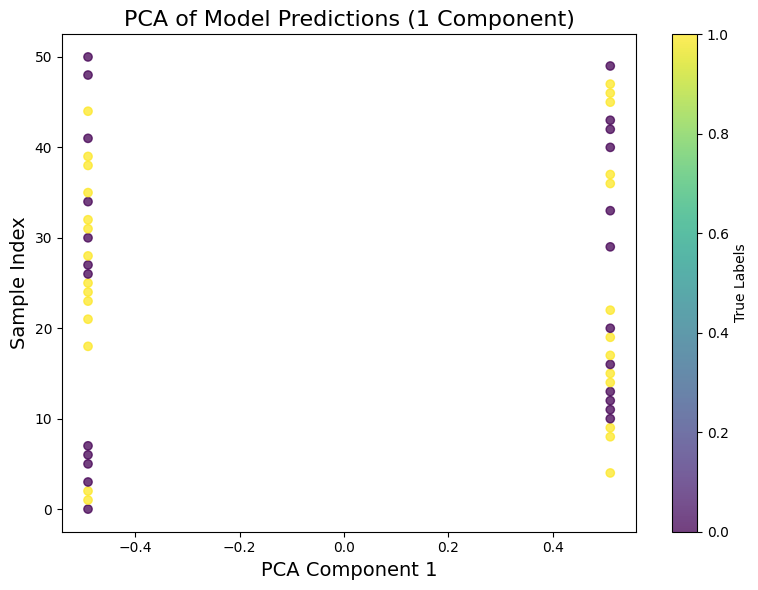

In [49]:
if y_pred.ndim == 1:
    labels_test_reshaped = y_pred.reshape(-1, 1)

pca = PCA(n_components=1)
features_pca = pca.fit_transform(labels_test_reshaped)

plt.figure(figsize=(8, 6))

plt.scatter(features_pca, range(len(features_pca)), c=y_test_numpy, cmap='viridis', alpha=0.75)

plt.colorbar(label='True Labels')
plt.title('PCA of Model Predictions (1 Component)', fontsize=16)
plt.xlabel('PCA Component 1', fontsize=14)
plt.ylabel('Sample Index', fontsize=14)

plt.tight_layout()
plt.show()

#### Plot the confusion matrix

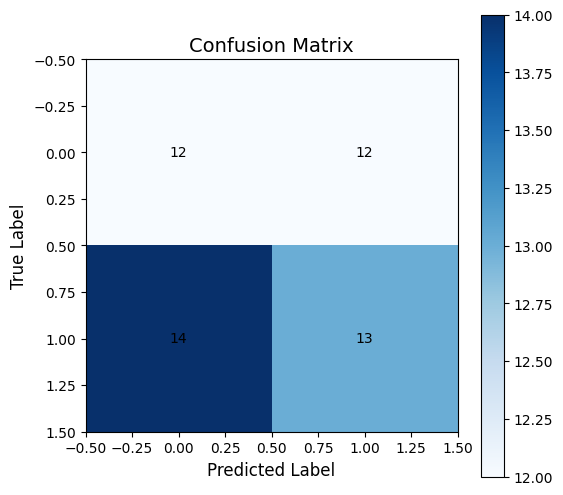

In [50]:
plt.figure(figsize=(6, 6))
plt.title("Confusion Matrix", fontsize=14)
plt.imshow(conf_matrix, interpolation="nearest", cmap=plt.cm.Blues, aspect='equal')
plt.colorbar()

plt.xlabel("Predicted Label", fontsize=12)
plt.ylabel("True Label", fontsize=12)

for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, f"{conf_matrix[i, j]}", ha="center", va="center", color="black", fontsize=10)

plt.show()

#### Plot the ROC curve

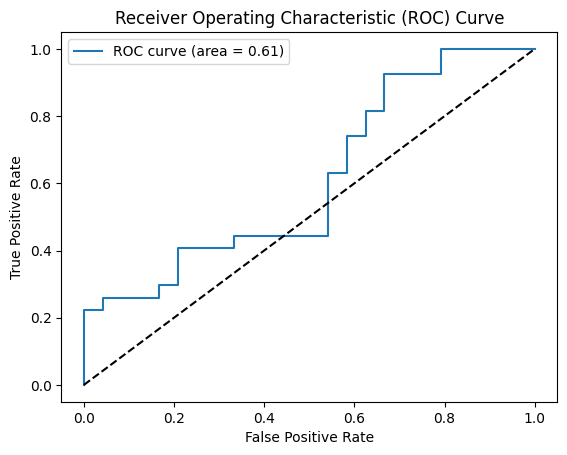

In [51]:
decision_function = qsvc.decision_function(X_test_numpy)

fpr, tpr, _ = metrics.roc_curve(y_test_numpy, decision_function)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (area = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], "k--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="best")

plt.show()

In [52]:
import utils.tutorial_magics

%qiskit_version_table
%qiskit_copyright